Task:
Analyzing the content of the E-Commerce database that contains the purchases made by approximate ~4000 customers over a period of one year
To develop a model that allows to anticipate or predict the purchases that will be made by a new customer during the following & this year, based on the data available from the previous purchases.


In [39]:
# Importing all the required libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import plotly
plotly.offline.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual,VBox,HBox,Layout
import ipywidgets as widgets




In [40]:
import pandas as pd

# making data frame from csv file
data = pd.read_csv(r"C:\Users\santh\Downloads\Datasets\E-commerce.csv",encoding="ISO-8859-1")

# generating one row
df = data.sample(frac =.10)


In [41]:
df.count()

InvoiceNo      54191
StockCode      54191
Description    54048
Quantity       54191
InvoiceDate    54191
UnitPrice      54191
CustomerID     40698
Country        54191
dtype: int64

In [42]:
df.describe()

Quantity     UnitPrice    CustomerID
count  54191.000000  54191.000000  40698.000000
mean       9.827813      4.107836  15291.737063
std       48.570347     38.269906   1718.711292
min    -3167.000000      0.000000  12347.000000
25%        1.000000      1.250000  13952.000000
50%        3.000000      2.080000  15150.000000
75%       10.000000      4.130000  16807.000000
max     3114.000000   4575.640000  18287.000000

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54191 entries, 297697 to 486361
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    54191 non-null  object 
 1   StockCode    54191 non-null  object 
 2   Description  54048 non-null  object 
 3   Quantity     54191 non-null  int64  
 4   InvoiceDate  54191 non-null  object 
 5   UnitPrice    54191 non-null  float64
 6   CustomerID   40698 non-null  float64
 7   Country      54191 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.7+ MB


In [44]:
df.isnull().sum()

InvoiceNo          0
StockCode          0
Description      143
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     13493
Country            0
dtype: int64

In [45]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Sales'] = df.Quantity*df.UnitPrice
df['Year']=df.InvoiceDate.dt.year
df['Month']=df.InvoiceDate.dt.month
df['Week']=df.InvoiceDate.dt.isocalendar().week
df['Year_Month']=df.InvoiceDate.dt.to_period('M')
df['Hour']=df.InvoiceDate.dt.hour
df['Day']=df.InvoiceDate.dt.day
df['is_cancelled']=df.InvoiceNo.apply(lambda x: 'Yes' if x[0]=='C' else 'No')
df['weekday'] = df.InvoiceDate.dt.day_name()
df['Quarter'] = df.Month.apply(lambda m:'Q'+str(ceil(m/4)))
df['Date']=pd.to_datetime(df[['Year','Month','Day']])
df.head()

InvoiceNo StockCode                         Description  Quantity  \
297697    562955    84660c            PINK STITCHED WALL CLOCK         3   
140622    548451     22707                   WRAP MONSTER FUN         50   
359228    568180     22534       MAGIC DRAWING SLATE SPACEBOY         12   
478086    577078    47369B  BLUE GREEN EMBROIDERY COSMETIC BAG         1   
381726   C569891     22720   SET OF 3 CAKE TINS PANTRY DESIGN         -2   

               InvoiceDate  UnitPrice  CustomerID         Country  Sales  \
297697 2011-08-11 10:14:00       7.46         NaN  United Kingdom  22.38   
140622 2011-03-31 11:25:00       0.42     17365.0  United Kingdom  21.00   
359228 2011-09-25 13:42:00       0.42     15429.0  United Kingdom   5.04   
478086 2011-11-17 15:17:00       5.79         NaN  United Kingdom   5.79   
381726 2011-10-06 15:46:00       4.95     13924.0  United Kingdom  -9.90   

        Year  Month  Week Year_Month  Hour  Day is_cancelled   weekday  \
297697  2011      8    32    2011-08    10   11           No  Thursday   
140622  2011      3    13    2011-03    11   31           No  Thursday   
359228  2011      9    38    2011-09    13   25           No    Sunday   
478086  2011     11    46    2011-11    15   17           No  Thursday   
381726  2011     10    40    2011-10    15    6          Yes  Thursday   

       Quarter       Date  
297697      Q2 2011-08-11  
140622      Q1 2011-03-31  
359228      Q3 2011-09-25  
478086      Q3 2011-11-17  
381726      Q3 2011-10-06

CustomerID and Description is missing.Since it represents 25% of the data This would affect in finding Potential customers

<BarContainer object of 2 artists>

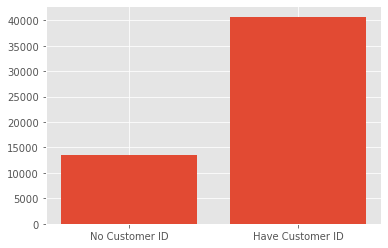

In [46]:
import matplotlib.pyplot as plt

no_customer_id = len(df[df['CustomerID'].isnull()].index)
have_customer_id = len(df[~df['CustomerID'].isnull()].index)

plt.bar(['No Customer ID','Have Customer ID'],[no_customer_id, have_customer_id])


In [47]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=df.UnitPrice),row=1, col=1)
fig.add_trace(go.Box(y=df.Quantity),row=1, col=2)
fig.add_trace(go.Box(y=df.Sales),row=1, col=3)

fig.update_xaxes(title_text="Unit Price", row=1, col=1)
fig.update_xaxes(title_text="Quantity", row=1, col=2)
fig.update_xaxes(title_text="Sales", row=1, col=3)

fig.update_layout(height=500, width=700)
fig.show()

In [48]:
df_=df[df.is_cancelled=='No']
del df

In [49]:
sales_by_date = df_.groupby(by='Date')['Sales'].sum().reset_index()
fig = go.Figure(data=go.Scatter(x=sales_by_date.Date,y=sales_by_date.Sales
                                ,line = dict(color='black', width=1.5)))
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Sales',template='ggplot2')
fig.show()

In [50]:
sales_by_hour = df_.groupby(by='Hour')['Sales'].sum().reset_index()
sales_by_weekday = df_.groupby(by='weekday')['Sales'].sum().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Total Hourly Sales", "Total Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()


del [sales_by_hour,sales_by_weekday]

In [51]:
customer_by_month1 = df_.groupby('CustomerID')['Date'].min().reset_index()
customer_by_month1['days'] = pd.TimedeltaIndex(customer_by_month1.Date.dt.day,unit="D")
customer_by_month1['Month'] = customer_by_month1.Date- customer_by_month1.days+pd.DateOffset(days=1)
customer_by_month1['Quarter_acquisition'] = customer_by_month1['Month'].dt.quarter.apply(lambda x:'Q'+str(x))
customer_by_month1['Year_acquisition'] = customer_by_month1['Month'].dt.year
customer_by_month = df_.groupby(by = customer_by_month1.Month)['CustomerID'].size().reset_index()
customer_by_month.sort_values(by ='Month',ascending=True,inplace=True)
customer_by_month['cum_customer'] = np.cumsum(customer_by_month.CustomerID)
customer_by_month['Month_1'] = customer_by_month['Month'].dt.strftime('%b-%y')

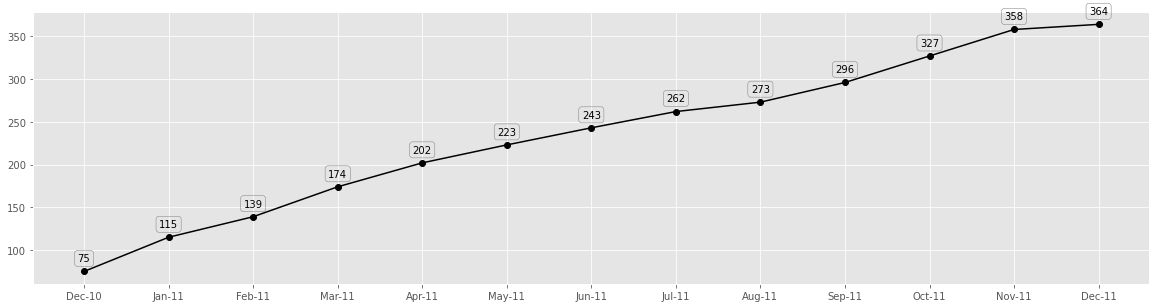

In [52]:
plt.style.use('ggplot')
plt.figure(figsize=(20,5))
plt.plot(customer_by_month.Month_1,customer_by_month.cum_customer,'bo-',color='black')

# zip joins x and y coordinates in pairs
for d,c in zip(customer_by_month['Month_1'],customer_by_month['cum_customer']):

    label = "{:.0f}".format(c)

    plt.annotate(label, 
                 (d,c), 
                 textcoords="offset points"
                 , bbox=dict(boxstyle="round", fc="none", ec="gray")
                 #,arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=10,rad=90")
                 ,xytext=(0,10),
                 ha='center') 
plt.show()

del customer_by_month


Customer acquisition VS Sales contribution

In [53]:
customer_sales = df_.groupby(by = ['CustomerID','Year','Quarter'])['Sales'].sum().reset_index()
customer_sales = customer_sales.merge(customer_by_month1[['CustomerID','Quarter_acquisition','Year_acquisition']]
                                      ,on ='CustomerID',how='inner')
customer_sales_acquisition = customer_sales.groupby(by=['Year','Quarter','Year_acquisition','Quarter_acquisition'])['Sales'].sum().reset_index()
customer_sales_acquisition['Sales_Year_quarter'] =customer_sales_acquisition[['Year','Quarter']].apply(lambda row:str(row.Year)+'-'+row.Quarter,axis=1)
customer_sales_acquisition['Acquisition_Year_quarter'] =customer_sales_acquisition[['Year_acquisition','Quarter_acquisition']].apply(lambda row:str(row.Year_acquisition)+'-'+row.Quarter_acquisition,axis=1)
customer_sales_acquisition.drop(columns =['Year','Quarter','Year_acquisition','Quarter_acquisition'],inplace=True)
df = customer_sales_acquisition.pivot(index='Sales_Year_quarter',columns =['Acquisition_Year_quarter']).fillna(0).reset_index()


fig = go.Figure(data=[
    go.Bar(name='First Order 2010-Q4', x=df.Sales_Year_quarter, y=df.iloc[:,1],marker_color='lightslategrey'),
    go.Bar(name='First Order 2011-Q1', x=df.Sales_Year_quarter, y=df.iloc[:,2],marker_color='lightblue'),
    go.Bar(name='First Order 2011-Q2', x=df.Sales_Year_quarter, y=df.iloc[:,3],marker_color='seagreen'),
    go.Bar(name='First Order 2011-Q3', x=df.Sales_Year_quarter, y=df.iloc[:,4],marker_color='orange')
])
fig.update_layout(barmode='stack',template='ggplot2')
fig.show()

del [customer_sales_acquisition, df,customer_sales]

Frequent purchasing:
Most of customers made their next purchase after one or two months of first purchase.
There were 28 customers who made their first purchase in Dec 2010 also made their next purchase after 12 months.33 customers made their second purchase after 7 months of their first purchase in Mar 2011.

Hourly sales

In [54]:
sales_by_hour = df_.groupby(by='Hour')['Sales'].mean().reset_index()
sales_by_weekday = df_.groupby(by='weekday')['Sales'].mean().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Avg Hourly Sales", "Avg Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()

del [sales_by_hour,sales_by_weekday]

In [55]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
model = ols('Sales ~ C(Hour)',data=df_).fit()
#ols.summary()
table = sm.stats.anova_lm(model, typ=2)
print(table)
del [table,model]

                sum_sq       df          F        PR(>F)
C(Hour)   1.884095e+06     13.0  21.977099  3.338199e-53
Residual  3.510245e+08  53229.0        NaN           NaN


In [56]:
LRFM = df_.groupby('CustomerID').agg(Frequency=pd.NamedAgg(column="InvoiceNo", aggfunc="nunique")
                                        ,Monetary=pd.NamedAgg(column="Sales", aggfunc="sum")).reset_index()

length = df_.groupby('CustomerID')['Date'].max() - df_.groupby('CustomerID')['Date'].min()
length =  (length/np.timedelta64(1, 'D')).reset_index()
length.columns = ['CustomerID','Length_of_stay']
LRFM = LRFM.merge(length,on='CustomerID',how='inner')
del length

LRFM.head()

CustomerID  Frequency  Monetary  Length_of_stay
0     12347.0          6    390.86           365.0
1     12348.0          3    302.16           110.0
2     12349.0          1    163.51             0.0
3     12350.0          1     33.70             0.0
4     12352.0          5    154.00           260.0

#### 3 Dimensional View

In [57]:
fig = go.Figure(data=[go.Scatter3d(x=LRFM.Monetary,y=LRFM.Length_of_stay,z=LRFM.Frequency,mode='markers'
                                   ,marker=dict(size=4,color='coral',colorscale='Viridis',opacity=0.8))])
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Frequency')),width=800,height=500)
fig.show()

K Means Clustering

In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

In [59]:
X=LRFM.drop(columns = 'CustomerID')
error = []
silhouette = []
np.random.seed(12)
rng = range(2,20)
for i in rng:
    km = KMeans(n_clusters=i, init='random',n_init=20, max_iter=200,tol=.0001, random_state=12)
    km.fit(X)
    error.append(km.inertia_)
    lbls = km.fit_predict(X)
    silhouette.append(silhouette_score(X, lbls))

fig = make_subplots(rows=1, cols=2,subplot_titles=("Number of Cluster vs Error", "Number of Cluster vs Silhouette"))
fig.add_trace(go.Scatter(x=list(rng), y=error),row=1, col=1)
fig.add_trace(go.Scatter(x=list(rng), y=silhouette),row=1, col=2)
fig.update_layout(height=500, width=800,template='ggplot2')
fig.update_xaxes(title_text="Number of Clusters", row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=2)
fig.update_yaxes(title_text="Errors", row=1, col=1)
fig.update_yaxes(title_text="Silhouette Distance", row=1, col=2)
fig.show()

del [error,silhouette,rng,km,lbls,X]

Creating Cluster

In [60]:
X=LRFM.drop(columns = 'CustomerID')
cluster_lbls = KMeans(n_clusters=10, random_state=12).fit_predict(X)
X['cluster'] = cluster_lbls
X['sample_silhouette_values'] = silhouette_samples(X, cluster_lbls)
X['txt']=X.cluster.apply(lambda x:'Cluster '+str(x))

Sample vs Silhouette

In [61]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.sample_silhouette_values
                                , mode='markers',marker_color=X.cluster,text = X.txt))

fig.update_layout(xaxis_title="Sales",yaxis_title="Silhouette"
                  ,title='Sample Size vs Silhoutte Values')

fig.show()


In [62]:
df = X.groupby('cluster').agg({'cluster':'size', 'Monetary':'mean','Frequency':'mean','Length_of_stay':'mean'}) \
       .rename(columns={'cluster':'Size','Monetary':'Avg Sales','Frequency':'Avg Recency','Length_of_stay':'Avg Lenght of Stay'}) \
       .reset_index().sort_values(by = 'Avg Sales')

cluster_map ={'Cluster 4':'lightskyblue','Cluster 0':'lightskyblue','Cluster 8':'lightskyblue'
              ,'Cluster 6':'lightskyblue','Cluster 2':'lightskyblue',
             'Cluster 3':'orange','Cluster 7':'orange','Cluster 9':'orange'
              ,'Cluster 1':'olive','Cluster 5':'olive'}

txt =['Size = {0:.0f}'.format(i) for i in df.Size]
df['cluster']=df.cluster.apply(lambda x:'Cluster '+str(x))
df['Group']=df.cluster.map(cluster_map)

fig = make_subplots(rows=1, cols=3,subplot_titles=("Avg Sales", "Avg Recency",'Avg Lenght of Stay'))

fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Sales'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Recency'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=2)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Lenght of Stay'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=3)

fig.update_traces(marker_line_color='rgb(8,48,107)', marker_line_width=1.5, opacity=0.8)
fig.update_layout(title_text='Cluster Size',width = 800,height=600,template='ggplot2'
                  ,font=dict(family="Courier New, monospace",size=10,color="RebeccaPurple"))

fig.show()

Cluster 3 Dimensional View

In [63]:
fig = go.Figure(data=[go.Scatter3d(x=X.Monetary,y=X.Length_of_stay,z=X.Frequency,mode='markers'
                                   ,marker=dict(size=4,color=X.cluster
                                                ,colorscale='Viridis',opacity=0.8))])

# tight layout
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Recency')),width=700,height=500)
fig.show()

Bivariate view

In [64]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.Length_of_stay
                                , mode='markers',marker_color=X.cluster,text=X.txt))
fig.update_layout(xaxis_title="Sales",yaxis_title="Length of Stay",title='Sales vs Length of Stay'
                  ,width=800,height=500)
fig.show()

In [65]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.Frequency
                                , mode='markers',marker_color=X.cluster,text=X.txt))
fig.update_layout(xaxis_title="Sales",yaxis_title="Frequency",title='Sales vs Frequency'
                  ,width=800,height=500)
fig.show()

### Time Series Forecasting

In [66]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [67]:
ds_weekly = df_.groupby(by=['Year','Week'])['Sales'].sum().reset_index()
ds_daily = df_.groupby(by=['Date'])['Sales'].sum().reset_index()

In [68]:
def plot_(t_train,t_test,x_train,x_test,x_train_pred,x_test_pred,forecast,title='Weekly'):
    xt = (max(t_test)+np.arange(len(forecast)))+1
    fig_train=go.Scatter(name='Train : Actual ',x=t_train,y=x_train,showlegend=True)
    fig_trian_pred=go.Scatter(name='Train : Predict',x=t_train,y=x_train_pred,showlegend=True)
    fig_test=go.Scatter(name='Test : Actual',x=t_test,y=x_test,showlegend=True)
    fig_test_pred=go.Scatter(name='Test : Predict',x=t_test,y=x_test_pred,showlegend=True)
    fig_forecast=go.Scatter(name='Forecast',x=xt,y=forecast,showlegend=True)

    fig = go.Figure([fig_train,fig_trian_pred,fig_test,fig_test_pred,fig_forecast])
    fig.update_layout(xaxis_title=title,yaxis_title="Sales",title=title +' Trend'
                      ,height=400,hovermode="x",template='ggplot2')
    fig.show()


Weekly sales

In [69]:
fig = go.Figure(data=[go.Scatter(x=ds_weekly.index,y=ds_weekly.Sales)])
fig.update_layout(xaxis_title="Week",yaxis_title="Sales",title='Weekly Trend',height=400,template='ggplot2')
fig.show()

Daily sales

In [70]:
fig = go.Figure(data=[go.Scatter(x=ds_daily.Date,y=ds_daily.Sales)])
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Trend',height=400,template='ggplot2')
fig.show()


Train-Test split

In [71]:
series_date=ds_daily.Sales
split_time = 250
time_d=np.arange(len(ds_daily))
xtrain_d=series_date[:split_time]
xtest_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',xtrain_d.shape)
print('Testing Set Size ',xtest_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [72]:
series=ds_weekly.Sales
split_time = 45
time=np.arange(len(ds_weekly))
xtrain=series[:split_time]
xtest=series[split_time:]
timeTrain = time[:split_time]
timeTest = time[split_time:]
print('Full Set Size ',series.shape)
print('Training Set Size ',xtrain.shape)
print('Testing Set Size ',xtest.shape)

Full Set Size  (53,)
Training Set Size  (45,)
Testing Set Size  (8,)


In [73]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(xtrain, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   45
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -448.209
Date:                Tue, 29 Dec 2020   AIC                            904.418
Time:                        23:49:31   BIC                            911.555
Sample:                             0   HQIC                           907.065
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3514      2.551     -0.138      0.890      -5.352       4.649
ma.L1         -0.4119      2.557     -0.161      0.872      -5.424       4.601
ma.L2         -0.3531      1.986     -0.178      0.8

## Time-series Model -ARIMA

In [74]:
from statsmodels.tsa.arima.model import ARIMA
s_model = ARIMA(endog=xtrain_d , order=(1, 1, 1))
s_model_fit=s_model.fit()
print(s_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2258.562
Date:                Tue, 29 Dec 2020   AIC                           4523.124
Time:                        23:49:32   BIC                           4533.676
Sample:                             0   HQIC                          4527.371
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0430      0.103      0.415      0.678      -0.160       0.246
ma.L1         -0.9392      0.039    -24.195      0.000      -1.015      -0.863
sigma2      4.398e+06   1.18e+05     37.393      0.0

In [75]:
ytrain_pred = model_fit.predict()
ytest_pred = model_fit.predict(start=min(timeTest),end=max(timeTest),dynamic=True)
print('MSE Train :',np.sqrt(np.mean((ytrain_pred - xtrain)**2)))
print('MSE Test :',np.sqrt(np.mean((ytest_pred - xtest)**2)))
forecast = model_fit.forecast(20, alpha=0.05)
plot_(t_train = timeTrain,t_test = timeTest,x_train = xtrain,x_test = xtest,x_train_pred = ytrain_pred
      ,x_test_pred = ytest_pred,forecast = forecast,title='Weekly')

MSE Train : 6964.934511960026
MSE Test : 10712.088810144862


In [77]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.api import het_goldfeldquandt
from sklearn.metrics import r2_score

In [78]:
xtrain1,xtest1,ytrain1,ytest1 = train_test_split(LRFM[['Frequency', 'Length_of_stay']],LRFM.Monetary
                                             ,test_size=.3,random_state=49,shuffle=True)
print(xtrain1.shape)
print(xtest1.shape)

(2664, 2)
(1142, 2)
